In [3]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from prettytable import PrettyTable

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.model_selection import StratifiedKFold
import graphviz

# Import the data

In [0]:
import pandas as pd
final = pd.read_csv("final.csv") #csv file which consists of Amazon food reviews with data cleaning performed upon previously
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(142897) #Gets 1000 reviews of positive and negative scores
neg_2000 = neg.sample(57103)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
print("The shape of grouped data is {}".format(grouped_data.shape))

Observations:
We choose 142897 positive and 57103 negative reviews from the final dataframe obtained after data cleaning process.

In [0]:
import datetime
grouped_data['Time'] = grouped_data['Time'].map(lambda a: datetime.datetime.fromtimestamp(int(a)).strftime('%Y-%m-%d %H:%M:%S'))
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores = grouped_data['Score']
print("The shape of grouped data after time based splitting is {}".format(grouped_data.shape))

Observations:
Time based splitting is done on the obtained dataframe.

In [0]:
grouped_data.to_csv("grouped_data_200")

Observations:
Saving this dataframe into a new csv file.

# Utility Function

In [2]:
#We create a few utility functions whose use is described below


def decision_trees(x_train,y_train,x_test,y_test,words,tree_name): 
    #This function implements the decision trees, gets confusion matrix and gets feature importances
    my_cv = TimeSeriesSplit(n_splits=3).split(x_train)
    param_max_depth = {'max_depth' : list(range(1,1000,10))} #Parameter max_depth for grid search
    model1 = DecisionTreeClassifier(min_samples_split=50, min_samples_leaf=50)
    f1_scorer = make_scorer(f1_score, pos_label='Positive') #This lets the f1 scorer know that positive label is 'Positive'
    
    gsearch1 = GridSearchCV(estimator = model1, param_grid = param_max_depth,cv=my_cv, scoring = f1_scorer) #Initiate GridsearchCV
    gsearch1.fit(x_train, y_train) #Fitting the model
    
    print("The optimal max depth value found using GridSearchCV is",gsearch1.best_params_['max_depth'])
    print("The best CV value found is",gsearch1.best_index_)
    
    gpred1 = gsearch1.predict(x_test) #Predicting test data
    print('\nThe test accuracy of SVM for max_depth = %d is %f%%' % (gsearch1.best_params_['max_depth'], accuracy_score(y_test, gpred1) * 100))
    print('\nThe test precision of SVM for max_depth = %d is %f%%' % (gsearch1.best_params_['max_depth'], precision_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test recall of SVM for max_depth = %d is %f%%' % (gsearch1.best_params_['max_depth'], recall_score(y_test,gpred1,pos_label='Positive')*100))
    print('\nThe test f1 score of SVM for max_depth = %d is %f%%' % (gsearch1.best_params_['max_depth'], f1_score(y_test,gpred1,pos_label='Positive')*100))
    print('*'*50)
    
    
    #Plot confusion matrix
    
    #We are using 2 types of confusion matrix here. SKLearn confusion matrix and pandas_ml confusion matrix.
    #SKLearn confusion matrix is used to plot it diagramatically whereas pandas_ml confusion matrix is used just for intresting stats like TPR, TNR etc..
    
    y_true = np.array(y_test) #Converting y_test and gpred1 to array for input into pandas_ml Confusion matrix
    y_pred = np.array(gpred1)
    labels = ['Negative','Positive']
    print(confusion_matrix(y_test, gpred1)) #This prints TP, TN, FP, FN numerically before plotting it diagramatically.
    cm = ConfusionMatrix(np.where(y_true == 'Positive', True, False), np.where(y_pred == 'Negative',False, True)) #This the confusion matrix of pandas_ml which provides interesting stats.
    confusion_matrix_plot = confusion_matrix(y_test,gpred1) #We are plotting confusion matrix of sklearn
    heatmap = sns.heatmap(confusion_matrix_plot, annot=True,cmap='Blues', fmt='g',xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'])
    plt.title('Confusion matrix of the classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print("*"*50)
    print("The True Positive Rate observed is",cm.TPR) #This prints the True Positive Rate of the confusion matrix (using pandas_ml confusion matrix).
    print("The True Negative Rate observed is",cm.TNR)
    print("The False Positive Rate observed is",cm.FPR)
    print("The False Negative Rate observed is",cm.FNR)
    print("*"*50)
    print("The stats observed for confusion matrix are:")
    cm.print_stats()#Prints all the stats of the confusion matrix plotted (using pandas_ml confusion matrix).
    
    print('\n')
    
    
    #Get feature Importances
    
    clf = gsearch1.best_estimator_
    clf.fit(x_train,y_train)
    feat_imps = clf.feature_importances_ #Storing the feature importances into a new variable
    
    if len(x_train[0])!=len(words): #This checks if the n_features matches with the number of words. Only matches for BOW and TFIDF.
        words==None #If they dont match then feature names in the decision tree graph will be set to None.
    
    print('\n')
    print('*'*70)
    dot_data = export_graphviz(clf, out_file=None, filled=True, rounded=True, feature_names=words) #Plots the decision tree graph
    graph = graphviz.Source(dot_data) 
    graph.render(tree_name) #Saves it into a desired file name
        
    print('The number of words available are', len(words))
    
    if words == None: #If the n_features is not equal to number of words, a dataframe is output with important features.
        df = 0 #If input is 0 the data frame is not obtained.        
    else:
        df = pd.DataFrame({'Words': words, 'Coefficients':feat_imps}) #Create a dataframe for feature importances of all the words
    
    return df
  
def plot_graph(x_train,y_train,x_test,y_test,cv,step): #For plotting the hyper parameter against various errors
    print('*'*28,"Plotting max depth, Error",'*'*28)
    test_error=[]
    cv_scores=[]
   
    f1_scorer = make_scorer(f1_score, pos_label='Positive')
    param_list=list(range(1,1000,step)) #Here step determines the number of points to take for plotting.
    
    for i in param_list:
        model=DecisionTreeClassifier(max_depth=i,min_samples_split=50, min_samples_leaf=50) #Define decision tree model
        model.fit(x_train,y_train)
        test_error.append(1-accuracy_score(y_test, model.predict(x_test))) #Get the test error
        scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=f1_scorer)
        cv_scores.append(scores.mean()) #The mean of the obtained scores is taken #Get the CV scores
    
    MSE = [1 - x for x in cv_scores] #Gets the MSE
    
    plt.figure(1)
    plt.plot([a for a in param_list], test_error)

    plt.xlim(0,1001)
    plt.ylim(0,0.7)
    plt.title('Max Depth vs Test Error')
    plt.xlabel('Max Depth')
    plt.ylabel('Test Error')
    plt.show()
    
    plt.figure(2)
    plt.plot([a for a in param_list], MSE)

    plt.xlim(0,1001)
    plt.ylim(0,0.7)
    plt.title('Max Depth vs MSE')
    plt.xlabel('Max Depth')
    plt.ylabel('MSE')
    plt.show()

**Observations:**

1) The first function finds the maximum depth value for DecisionTreeClassifier, plots confusion matrix and lists all of its stats using GridsearchCV. 

2) It also returns a dataframe with all the important features, and plots the decision tree. 

3) The second function plots the max depth vs various errors.

# Bag of Words

In [5]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(30000) #Gets 30000 reviews of positive and 20000 negative scores
neg_2000 = neg.sample(20000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (49998, 14)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 50000 data points.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(grouped_data,scores,test_size=0.3,shuffle=False)

Observations:
The data is split into train and test.

In [7]:
count_vect = CountVectorizer()
vocab = count_vect.fit(x_train['CleanedText'].values.astype('U'))
data_train = count_vect.transform(x_train['CleanedText'].values.astype('U'))
data_test = count_vect.transform(x_test['CleanedText'].values.astype('U'))
words = count_vect.get_feature_names()
print("The shape of train data for BOW is {}".format(data_train.shape))
print("The shape of test data for BOW is {}".format(data_test.shape))

The shape of train data for BOW is (34998, 23628)
The shape of test data for BOW is (15000, 23628)


Observations:
We build out Bag of words vocabulary only on train data and get vectors of train and test data.

In [8]:
from sklearn.preprocessing import normalize
data_train=normalize(data_train)
data_test=normalize(data_test)

Observations: We normalize the data.

The optimal max depth value found using GridSearchCV is 21
The best CV value found is 2

The test accuracy of SVM for max_depth = 21 is 75.425028%

The test precision of SVM for max_depth = 21 is 78.463357%

The test recall of SVM for max_depth = 21 is 78.075747%

The test f1 score of SVM for max_depth = 21 is 78.269072%
**************************************************
[[4675 1822]
 [1864 6638]]


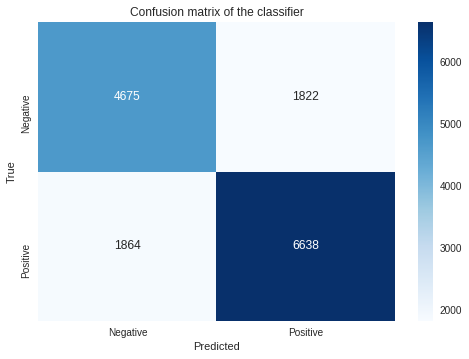

**************************************************
The True Positive Rate observed is 0.7807574688308633
The True Negative Rate observed is 0.7195628751731569
The False Positive Rate observed is 0.28043712482684313
The False Negative Rate observed is 0.21924253116913667
**************************************************
The stats observed for confusion matrix are:
population: 14999
P: 8502
N: 6497
PositiveTest: 8460
NegativeTest: 6539
TP: 6638
TN: 4675
FP: 1822
FN: 1864
TPR: 0.7807574688308633
TNR: 0.7195628751731569
PPV: 0.7846335697399527
NPV: 0.7149411224957944
FPR: 0.28043712482684313
FDR: 0.2153664302600473
FNR: 0.21924253116913667
ACC: 0.7542502833522234
F1_score: 0.7826907204339111
MCC: 0.499947379106133
informedness: 0.5003203440040203
markedness: 0.49957469223574713
prevalence: 0.5668377891859457
LRP: 2.7840731476367284
LRN: 0.30468849732746117
DOR: 9.137440934124177
FOR: 0.28505887750420555




**********************************************************************
The number 

In [11]:
df = decision_trees(data_train, y_train, data_test, y_test,words, 'BagOfWords')

**************************** Plotting max depth, Error ****************************


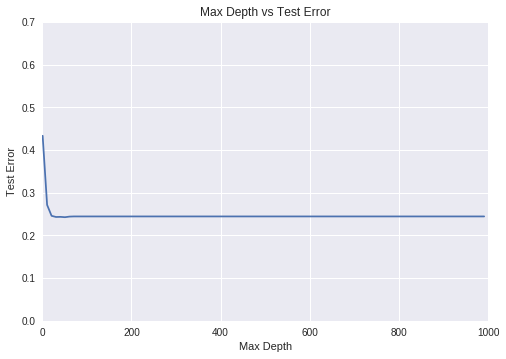

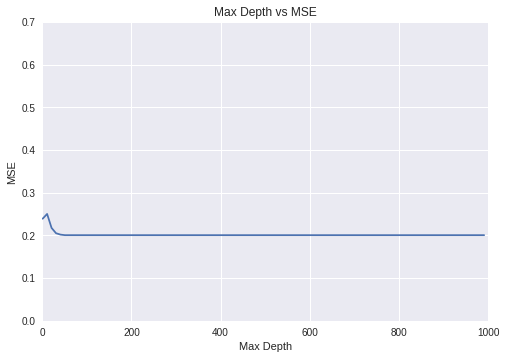

In [14]:
plot_graph(data_train, y_train, data_test, y_test, 2, 10)

In [16]:
df.sort_values(['Coefficients'], ascending=False).head(15)

,Coefficients,Words
8765,0.149587,great
5728,0.115459,disappoint
11871,0.097742,love
1825,0.074982,best
5322,0.057888,delici
8565,0.040831,good
13036,0.035665,money
20199,0.035453,tast
7228,0.032042,favorit
15009,0.031507,perfect


# TFIDF

In [10]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(8000) #Gets 30000 reviews of positive and 20000 negative scores
neg_2000 = neg.sample(7000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (14999, 12)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 15000 data points.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(grouped_data,scores,test_size=0.3,shuffle=False)

Observations: Data is split into train, test.

In [12]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit(x_train['CleanedText'].values.astype('U')) #Converts to a sparse matrix of TF-IDF vectors.
train_tf_idf = tf_idf_vect.transform(x_train['CleanedText'].values.astype('U'))
test_tf_idf = tf_idf_vect.transform(x_test['CleanedText'].values.astype('U'))
words = tf_idf_vect.get_feature_names()
print("the type of count vectorizer ",type(train_tf_idf))
print("The shape of train_tf_idf ",train_tf_idf.get_shape())
print("The shape of test_tf_idf ", test_tf_idf.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of train_tf_idf  (10499, 255735)
The shape of test_tf_idf  (4500, 255735)


Observations:
Vocabulary of TF-IDF is trained for train data and vectors for train and test data are obtained.

In [13]:
from sklearn.preprocessing import normalize
train_tf_idf=normalize(train_tf_idf)
test_tf_idf=normalize(test_tf_idf)

Observations:
Data is normalized.

The optimal max depth value found using GridSearchCV is 21
The best CV value found is 2

The test accuracy of SVM for max_depth = 21 is 74.022222%

The test precision of SVM for max_depth = 21 is 72.268908%

The test recall of SVM for max_depth = 21 is 79.141104%

The test f1 score of SVM for max_depth = 21 is 75.549048%
**************************************************
[[1525  693]
 [ 476 1806]]


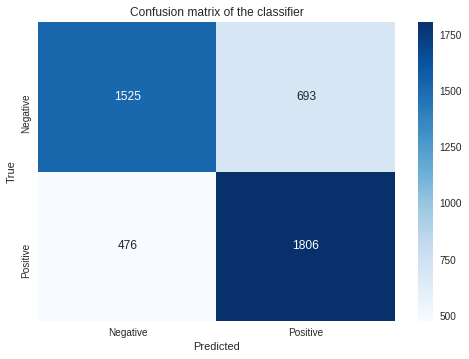

**************************************************
The True Positive Rate observed is 0.7914110429447853
The True Negative Rate observed is 0.6875563570784491
The False Positive Rate observed is 0.31244364292155097
The False Negative Rate observed is 0.2085889570552147
**************************************************
The stats observed for confusion matrix are:
population: 4500
P: 2282
N: 2218
PositiveTest: 2499
NegativeTest: 2001
TP: 1806
TN: 1525
FP: 693
FN: 476
TPR: 0.7914110429447853
TNR: 0.6875563570784491
PPV: 0.7226890756302521
NPV: 0.7621189405297352
FPR: 0.31244364292155097
FDR: 0.2773109243697479
FNR: 0.2085889570552147
ACC: 0.7402222222222222
F1_score: 0.7554904831625183
MCC: 0.48187885926918533
informedness: 0.47896740002323446
markedness: 0.48480801615998725
prevalence: 0.5071111111111111
LRP: 2.5329721403341035
LRN: 0.3033772503268631
DOR: 8.349248790425262
FOR: 0.23788105947026486




**********************************************************************
The number of 

In [0]:
df = decision_trees(train_tf_idf, y_train, test_tf_idf, y_test, words, 'TFIDF')

**************************** Plotting max depth, Error ****************************


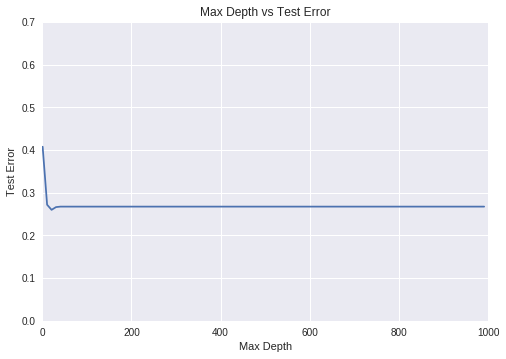

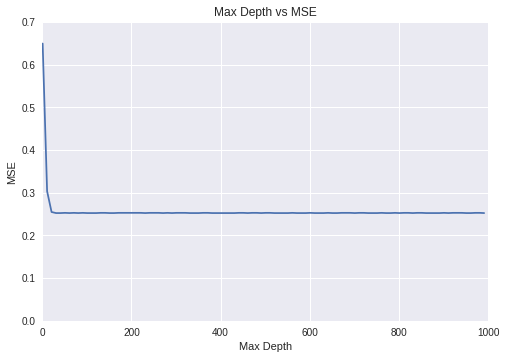

In [0]:
plot_graph(train_tf_idf, y_train, test_tf_idf, y_test, 2, 10)

In [0]:
df.sort_values(['Coefficients'], ascending=False).head(15)

,Coefficients,Words
97288,0.171161,great
128186,0.107516,love
19122,0.091522,best
61507,0.090033,disappoint
57609,0.069811,delici
78858,0.043012,favorit
160128,0.040504,perfect
94665,0.038972,good
104346,0.028018,high recommend
139769,0.022260,money


#  Avg Word2Vec

In [32]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(30000) #Gets 30000 reviews of positive and 20000 negative scores
neg_2000 = neg.sample(20000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (49995, 12)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 50000 data points.

In [33]:
x_train, x_test, y_train, y_test = train_test_split(grouped_data,scores,test_size=0.3,shuffle=False)

Observations: Data is split into train and test.

In [34]:
list_of_sent=[]
for sent in x_train['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(x_train['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

love stuff doesnt rot gum tast good go buy gum get
*****************************************************************
['love', 'stuff', 'doesnt', 'rot', 'gum', 'tast', 'good', 'go', 'buy', 'gum', 'get']


Observations: Get a list of all the words in train data.

In [35]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=200, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  8282
sample words  ['monkey', 'bone', 'copi', 'strang', 'fail', 'wasnt', 'review', 'came', 'that', 'critic', 'think', 'effect', 'energet', 'perform', 'plot', 'year', 'there']


Observations: Train the word2vec model on the obtained list of train words.

In [36]:
sent_vectors = [];
sent_list = []
for sent in x_test['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            vec = w2v_train.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

14999
200


Observations: Gets the sentence vectors for test data.

In [37]:
sent_vectors_train = [];
sent_list = []
for sent in x_train['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            vec = w2v_train.wv[word] #Gets the corresponding vector for the word
            sent_vec += vec
            i += 1
    if i != 0:
        sent_vec /= i
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

34996
200


Observations: Gets the sentence vectors for train data

In [38]:
from sklearn.preprocessing import normalize
data_train=normalize(sent_vectors_train)
data_test=normalize(sent_vectors)

Observations: Normalize the data.

The optimal max depth value found using GridSearchCV is 321
The best CV value found is 32

The test accuracy of SVM for max_depth = 321 is 76.100000%

The test precision of SVM for max_depth = 321 is 77.906186%

The test recall of SVM for max_depth = 321 is 80.789566%

The test f1 score of SVM for max_depth = 321 is 79.321682%
**************************************************
[[4539 1950]
 [1635 6876]]


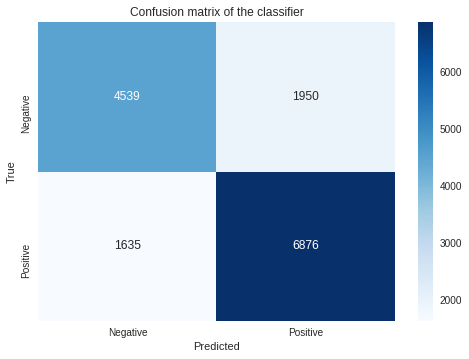

**************************************************
The True Positive Rate observed is 0.8078956644342615
The True Negative Rate observed is 0.6994914470642626
The False Positive Rate observed is 0.3005085529357374
The False Negative Rate observed is 0.19210433556573844
**************************************************
The stats observed for confusion matrix are:
population: 15000
P: 8511
N: 6489
PositiveTest: 8826
NegativeTest: 6174
TP: 6876
TN: 4539
FP: 1950
FN: 1635
TPR: 0.8078956644342615
TNR: 0.6994914470642626
PPV: 0.77906186267845
NPV: 0.7351797862001944
FPR: 0.3005085529357374
FDR: 0.22093813732154996
FNR: 0.19210433556573844
ACC: 0.761
F1_score: 0.793216819518948
MCC: 0.5108028825650592
informedness: 0.5073871114985242
markedness: 0.5142416488786443
prevalence: 0.5674
LRP: 2.688428187955858
LRN: 0.2746342880559764
DOR: 9.78912067748765
FOR: 0.26482021379980564




**********************************************************************
The number of words available are 34998


In [42]:
df = decision_trees(sent_vectors_train, y_train, sent_vectors, y_test, list_of_sent, 'Word2Vec')

**************************** Plotting max depth, Error ****************************


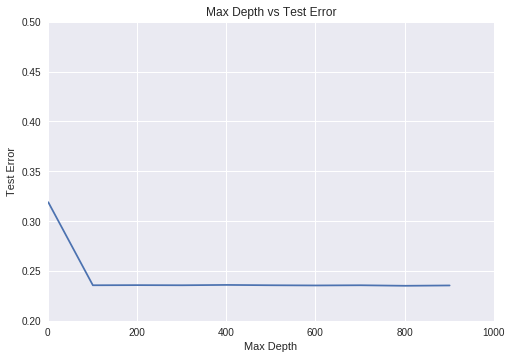

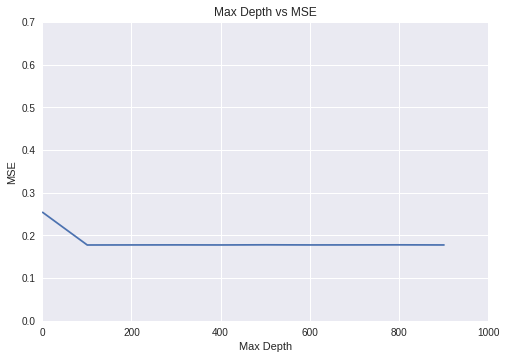

In [11]:
plot_graph(data_train, y_train, data_test, y_test,32,100)

# TFIDF Word2Vec

In [48]:
import pandas as pd
final = pd.read_csv("grouped_data_200.csv")
p = final.groupby('Score')
pos = p.get_group('Positive') #Gets the groups with Positive score
neg = p.get_group('Negative') #Gets the groups with Negative score
pos_2000 = pos.sample(30000) #Gets 30000 reviews of positive and 20000 negative scores
neg_2000 = neg.sample(20000)
grouped_data = pd.concat([pos_2000, neg_2000], ignore_index = True) #This data now contains positive and negative data in order.
grouped_data.dropna(inplace = True) #Drops rows with Nan
grouped_data.reset_index(inplace=True) #Replaces missing indexes
grouped_data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
grouped_data = grouped_data.sort_values('Time', axis=0, ascending=True, kind='quicksort')
scores=grouped_data['Score']
print("The shape of grouped data is {}".format(grouped_data.shape))

The shape of grouped data is (49997, 12)


Observations:
A csv file is imported which consists of 200000 data points. These data points are already sorted on the basis of time. We create a new dataframe with over 50000 data points.

In [49]:
x_train, x_test, y_train, y_test = train_test_split(grouped_data,scores,test_size=0.3,shuffle=False)

In [50]:
list_of_sent=[]
for sent in x_train['CleanedText'].values: #Splits sentences into words and stores it in a list
    list_of_sent.append(sent.split())
print(x_train['CleanedText'].values[9])
print("*****************************************************************")
print(list_of_sent[9])

love meow mix cat love eat togther cat kittl use attack brother franci could get delious belend chicken liver buy pleas
*****************************************************************
['love', 'meow', 'mix', 'cat', 'love', 'eat', 'togther', 'cat', 'kittl', 'use', 'attack', 'brother', 'franci', 'could', 'get', 'delious', 'belend', 'chicken', 'liver', 'buy', 'pleas']


In [51]:
w2v_train=Word2Vec(list_of_sent,min_count=5,size=200, workers=4) #Initialises the Word2Vec model with words occuring more than 5 times.

w2v_train_words = list(w2v_train.wv.vocab) #This gives a dictionary of words which tells about the uniqueness of a word among other things.
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[298:315])

number of words that occured minimum 5 times  8180
sample words  ['amazon', 'pull', 'shelv', 'love', 'meow', 'mix', 'cat', 'eat', 'attack', 'brother', 'franci', 'chicken', 'liver', 'buy', 'pleas', 'roast', 'drink']


Observations:
Word2Vec model is built. We can see the number of times a word occured minimum 5 times.

In [52]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab_tf_idf = tf_idf_vect.fit(x_train['CleanedText'].values) #Converts to a sparse matrix of TF-IDF vectors.
train_tf_idf = tf_idf_vect.transform(x_train['CleanedText'].values)
test_tf_idf = tf_idf_vect.transform(x_test['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tfidf_feat, list(tf_idf_vect.idf_)))

Observations:
We build the vocabulary of TF-IDF on train data and obtain the vectors of train and test data.

In [53]:
sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
sent_list = []
for sent in x_train['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_train_words:
            try:
                vec = w2v_train.wv[word] # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
    row += 1
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

34997
200


Observations:
The vector form of train data is obtained.

In [54]:
sent_vectors_test = [];
row=0
sent_list = []
for sent in x_test['CleanedText'].values:
    sent_list.append(sent.split())
for sent in sent_list: # For a sentence in the previously created list of sentences
    sent_vec = np.zeros(200) # As word vectors are of zero length, returns an array of size 50 filled with zeros
    i = 0; # Number of words with a valid vector in the sentence/review
    for word in sent: # For each word in a review/sentence
        if word in w2v_train_words:
            try:
                vec = w2v_train.wv[word] #Gets the corresponding vector for the word
                tf_idf = tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                i += tf_idf
            except:
                pass
    if i != 0:
        sent_vec /= i
    sent_vectors_test.append(sent_vec)
    row+=1
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

15000
200


Observations:
The vector form of test data is obtained.

The optimal max depth value found using GridSearchCV is 561
The best CV value found is 56

The test accuracy of SVM for max_depth = 561 is 73.513333%

The test precision of SVM for max_depth = 561 is 74.566349%

The test recall of SVM for max_depth = 561 is 80.870076%

The test f1 score of SVM for max_depth = 561 is 77.590389%
**************************************************
[[4149 2346]
 [1627 6878]]


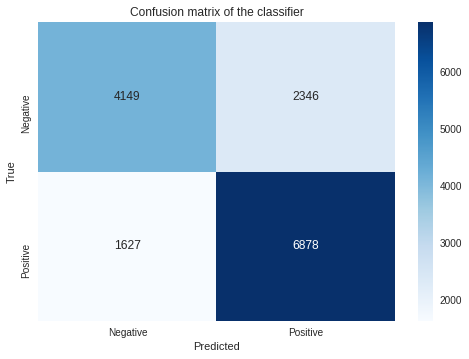

**************************************************
The True Positive Rate observed is 0.8087007642563198
The True Negative Rate observed is 0.6387990762124711
The False Positive Rate observed is 0.3612009237875289
The False Negative Rate observed is 0.19129923574368018
**************************************************
The stats observed for confusion matrix are:
population: 15000
P: 8505
N: 6495
PositiveTest: 9224
NegativeTest: 5776
TP: 6878
TN: 4149
FP: 2346
FN: 1627
TPR: 0.8087007642563198
TNR: 0.6387990762124711
PPV: 0.7456634865568084
NPV: 0.7183171745152355
FPR: 0.3612009237875289
FDR: 0.2543365134431917
FNR: 0.19129923574368018
ACC: 0.7351333333333333
F1_score: 0.7759038862880027
MCC: 0.45566574570659113
informedness: 0.4474998404687909
markedness: 0.46398066107204383
prevalence: 0.567
LRP: 2.238922192602215
LRN: 0.29946698870937644
DOR: 7.476357251433215
FOR: 0.28168282548476453




**********************************************************************
The number of words avail

In [0]:
df = decision_trees(sent_vectors_train, y_train, sent_vectors_test, y_test, list_of_sent, 'TFIDF_Word2vec')

**************************** Plotting max depth, Error ****************************


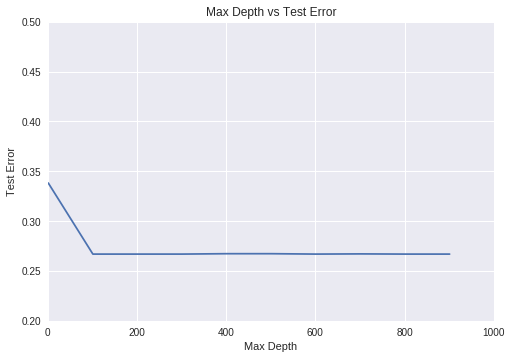

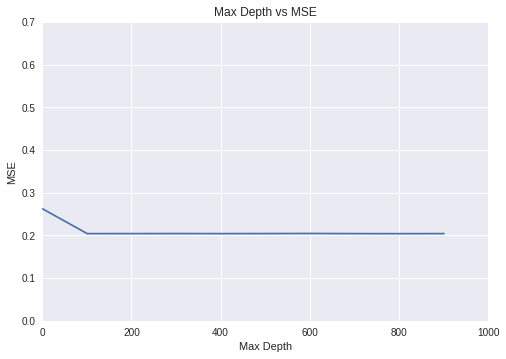

In [0]:
plot_graph(sent_vectors_train, y_train, sent_vectors_test, y_test,56,100)

# Summary and Conclusions

1) Import the csv file containing pre processed data which is already arranged on the basis of time.

2) Two functions are created for DecisionTreeClassifier and to plot max depth vs errors.

3) The first function performs GridSearchCv on max_depth and finds the right hyper parameter for DecisionTreeClassifier. Then the model is fitted and its respective accuracy and precision values are obtained. Then a Confusion matrix is plotted and its various values like TPR, TNR, FPR, FNR are obtained. A decision tree graph is saved as PDF using graphviz. Then a dataframe is constructed with all the words and their feature importances and it is given as output.

4) The second function plots the hyperparameter which is max_depth versus test error and MSE. Since it is computationally expensive a step size can be input into the function which will in turn decide the number of points to be taken for plotting the graph.

5) These functions are applied on Bag of Words, TFIDF, avg Word2Vec and TFIDF Word2Vec.

In [27]:
x = PrettyTable()
x.field_names = ["Model","Hyper Parameter", "Test Accuracy","Precision","Recall","F1 Score"]
x.add_row(["Bag of Words","max_depth = 21","75.42%", "72.46%", "78.07%", "78.26%"])
x.add_row(["","","","","",""])
x.add_row(["TFIDF","max_depth = 21","74.02%", "72.26%", "79.14%", "75.54%"])
x.add_row(["","","","","",""])
x.add_row(["Avg Word2vec","max_depth = 321","76.10%", "77.90%", "80.78%", "79.32%"])
x.add_row(["","","","","",""])
x.add_row(["TFIDF Word2vec","max_depth = 561","73.51%", "74.56%", "80.87%", "77.59%"])
x.add_row(["","","","","",""])

print(x.get_string())
print('*'*120)

z = PrettyTable()
z.field_names = ["Feature Importance for Bag of words","Feature Importance for TFIDF" ]
z.add_row(["great","great"])
z.add_row(["",""])
z.add_row(["dissapoint","love"])
z.add_row(["",""])
z.add_row(["love","best"])
z.add_row(["",""])
z.add_row(["best","dissapoint"])
z.add_row(["",""])
z.add_row(["delci","delci"])
z.add_row(["",""])

print(z.get_string())

+----------------+-----------------+---------------+-----------+--------+----------+
|     Model      | Hyper Parameter | Test Accuracy | Precision | Recall | F1 Score |
+----------------+-----------------+---------------+-----------+--------+----------+
|  Bag of Words  |  max_depth = 21 |     75.42%    |   72.46%  | 78.07% |  78.26%  |
|                |                 |               |           |        |          |
|     TFIDF      |  max_depth = 21 |     74.02%    |   72.26%  | 79.14% |  75.54%  |
|                |                 |               |           |        |          |
|  Avg Word2vec  | max_depth = 321 |     76.10%    |   77.90%  | 80.78% |  79.32%  |
|                |                 |               |           |        |          |
| TFIDF Word2vec | max_depth = 561 |     73.51%    |   74.56%  | 80.87% |  77.59%  |
|                |                 |               |           |        |          |
+----------------+-----------------+---------------+-----------+-